In [1]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, Union, Tuple, List, Dict
from sklearn.metrics.pairwise import cosine_similarity

COLOR_MAP = 'viridis'

EXPR_NAME = 'grad_expr_phi'
EXPR_SUB_NAME = 'phi_grad_4k' 
ATTN_DATA_DIR = os.path.join(os.environ['NNSCALER_STORE'], EXPR_NAME, EXPR_SUB_NAME)

## Data Loading

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load attention scores and gradients
def load_attention_data(
    iter_list, 
    base_dir=ATTN_DATA_DIR,
    mmap_mode=None,
):
    data = {}
    for iter_idx in sorted(os.listdir(base_dir)):
        iter_idx = int(iter_idx)
        if len(iter_list) > 0 and iter_idx not in iter_list:
            continue

        print('-' * 80)
        print(f'Loading data for iteration {iter_idx}')
        iter_path = os.path.join(base_dir, str(iter_idx))

        data[iter_idx] = {}
        for layer_idx in sorted(os.listdir(iter_path)):
            layer_idx = int(layer_idx)
            print('-' * 40)
            print(f'Loading data for layer {layer_idx}')
            layer_path = os.path.join(iter_path, str(layer_idx))

            data[iter_idx][layer_idx] = {}
    
            # Scan all files in layer_path
            rank_files = [f for f in os.listdir(layer_path) if f.endswith('.npy')]
            for rank_file in rank_files:
                data_type, rank = rank_file.split('.')[0].split('_')
                rank = int(rank)
                if rank not in data[iter_idx][layer_idx]:
                    data[iter_idx][layer_idx][rank] = {}

                print(f'Loading {data_type} data for rank {rank}...', end = ' ')
                try :
                    data[iter_idx][layer_idx][rank][data_type] = np.load(
                        os.path.join(layer_path, rank_file),
                        mmap_mode=mmap_mode,
                    )
                    print('Done.')
                except FileNotFoundError:
                    print('Failed (file not found).')
                    data[iter_idx][layer_idx][rank][data_type] = None

    return data

def load_single_data(
    iter_idx, 
    layer_idx, 
    rank, 
    batch_idx=0,
    base_dir=ATTN_DATA_DIR,
    return_tensor=True,
    mmap=False,
) -> Union[torch.Tensor, np.array]:
    print('-' * 80)
    print(f'Loading data for iteration {iter_idx}')
    iter_path = os.path.join(base_dir, str(iter_idx), str(layer_idx))

    attn_data_path = os.path.join(iter_path, f'attn_{rank}.npy')
    grad_data_path = os.path.join(iter_path, f'grad_{rank}.npy')

    if not return_tensor:
        attn_data = np.load(attn_data_path, mmap_mode='r' if mmap else None)
        grad_data = np.load(grad_data_path, mmap_mode='r' if mmap else None)
    else:
        attn_data = torch.from_numpy(np.load(attn_data_path, mmap_mode='r' if mmap else None)).to(device)
        grad_data = torch.from_numpy(np.load(grad_data_path, mmap_mode='r' if mmap else None)).to(device)
    return attn_data[batch_idx], grad_data[batch_idx]


## Data Visualization

In [9]:
def grad_softmax(attn_data: torch.Tensor, grad_data: torch.Tensor, temp: float = 1.0) -> torch.Tensor:
    c_prod = grad_data * attn_data
    c_sum = c_prod.sum(dim=-1, keepdim=True)
    return (c_prod - attn_data * c_sum) / temp

def plot_topk(axes: plt.Axes, x: torch.Tensor, topk: int = 100, causal: bool = False):
    values, indices = x.sort(dim=-1, descending=True)
    res = torch.zeros_like(values).scatter_(
        dim=-1, index=indices[:, :topk], 
        src=torch.ones_like(values)[:, :topk]
    )
    if causal:
        res[torch.arange(res.shape[0])[:, None] < torch.arange(res.shape[1])[None, :]] = 0

    axes.clear()
    sns.heatmap(res.cpu().numpy(), ax=axes, cmap=COLOR_MAP)

def plot_topv(axes: plt.Axes, x: torch.Tensor, topv: float = 0.8, causal: bool = False):
    if causal:
        x[torch.arange(x.shape[0])[:, None] < torch.arange(x.shape[1])[None, :]] = 0

    values, indices = x.sort(dim=-1, descending=True)
    src = torch.cumsum(values, dim=-1) < topv
    src = src.scatter(dim=-1, index=src.sum(dim=-1)[:, None], src=torch.ones_like(src)[:, :1]).to(values.dtype)
    res = torch.zeros_like(values).scatter_(dim=-1, index=indices, src=src)

    axes.clear()
    sns.heatmap(res.cpu().numpy(), ax=axes, cmap=COLOR_MAP)

def plot_attn_topk(
    axes: plt.Axes,
    attn_data: torch.Tensor,
    grad_data: torch.Tensor,
    topk: int = 100, 
    topv: float = None,
    causal: bool = False,
) -> Tuple[torch.Tensor, torch.Tensor]:
    plot_topk(axes[0][0], attn_data, topk=topk, causal=causal)
    axes[0][0].set_title(f'Attention (TopK={topk})')

    if topv is None:
        attn_sum = attn_data.sort(dim=-1, descending=True).values[:, :topk].sum(dim=-1)
        axes[0][1].barh(np.arange(attn_sum.shape[0]), attn_sum.flip(dims=(-1, )).cpu().numpy())
        axes[0][1].set_title(f'sum(top {topk})')
    else:
        plot_topv(axes[0][1], attn_data, topv=topv, causal=causal)
        axes[0][1].set_title(f'Attention (TopV={topv})')

    plot_topk(axes[1][0], grad_data.abs(), topk=topk, causal=causal)
    axes[1][0].set_title(f'abs(grad) (TopK={topk})')

    if topv is None:
        grad_sum = grad_data.abs().sort(dim=-1, descending=True).values[:, :topk].sum(dim=-1) / grad_data.abs().sum(dim=-1)
        axes[1][1].barh(np.arange(grad_sum.shape[0]), grad_sum.flip(dims=(-1, )).cpu().numpy())
        axes[1][1].set_title(f'sum(top {topk}) / sum()')
    else:
        # plot_topv(axes[1], grad_data.abs() / grad_data.abs().sum(dim=-1, keepdim=True), topv=topv, causal=causal)
        plot_topv(axes[1][1], grad_data.cpu.abs(), topv=topv, causal=causal)
        axes[1][1].set_title(f'abs(grad) (TopV={topv})')

    return attn_data, grad_data


def plot_attn_topv(
    axes: plt.Axes,
    attn_data: torch.Tensor,
    grad_data: torch.Tensor,
    topv: float = 0.8,
    causal: bool = False,
) -> Tuple[torch.Tensor, torch.Tensor]:
    plot_topv(axes[0], attn_data, topv=topv, causal=causal)
    axes[0].set_title(f'Attention (TopV={topv})')

    plot_topv(axes[1], grad_data.abs() / grad_data.abs().sum(dim=-1, keepdim=True), topv=topv, causal=causal)
    axes[1].set_title(f'abs(grad) / sum(abs(grad)) (TopV={topv})')

    return attn_data, grad_data

def rowwise_cosine_similarity(attn_data, grad_data, causal=False):
    """Calculates row-wise cosine similarity between attention weights and gradients."""
    similarities = []
    if causal:
        attn_data[torch.arange(attn_data.shape[0])[:, None] < torch.arange(attn_data.shape[1])[None, :]] = 0
        grad_data[torch.arange(attn_data.shape[0])[:, None] < torch.arange(attn_data.shape[1])[None, :]] = 0

    for row in range(attn_data.shape[0]):
        attn_row = attn_data[row].unsqueeze(0)  # Reshape for cosine_similarity
        grad_row = grad_data[row].unsqueeze(0)
        cos_sim = cosine_similarity(attn_row.cpu().numpy(), grad_row.cpu().numpy())[0, 0]
        similarities.append(cos_sim)
    return similarities

def plot_sim_hist(
    axes: plt.Axes,
    attn_data: torch.Tensor,
    grad_data: torch.Tensor,
    bins: int = 100,
    range: Tuple[float, float] = (-1, 1),
    causal: bool = False,
):
    similarities = rowwise_cosine_similarity(attn_data, grad_data.abs(), causal=causal)
    sns.histplot(similarities, bins=bins, binrange=range, ax=axes)

### Across Iterations

We randomly picked some attention heads from the model and check their attention distribution and corresponding gradients across different iterations to check their sparsity pattern relationship on different inputs.

#### Head = 0, Layer = 31

##### Average over iters

--------------------------------------------------------------------------------
Loading data for iteration 400


--------------------------------------------------------------------------------
Loading data for iteration 800
--------------------------------------------------------------------------------
Loading data for iteration 1600
--------------------------------------------------------------------------------
Loading data for iteration 2400


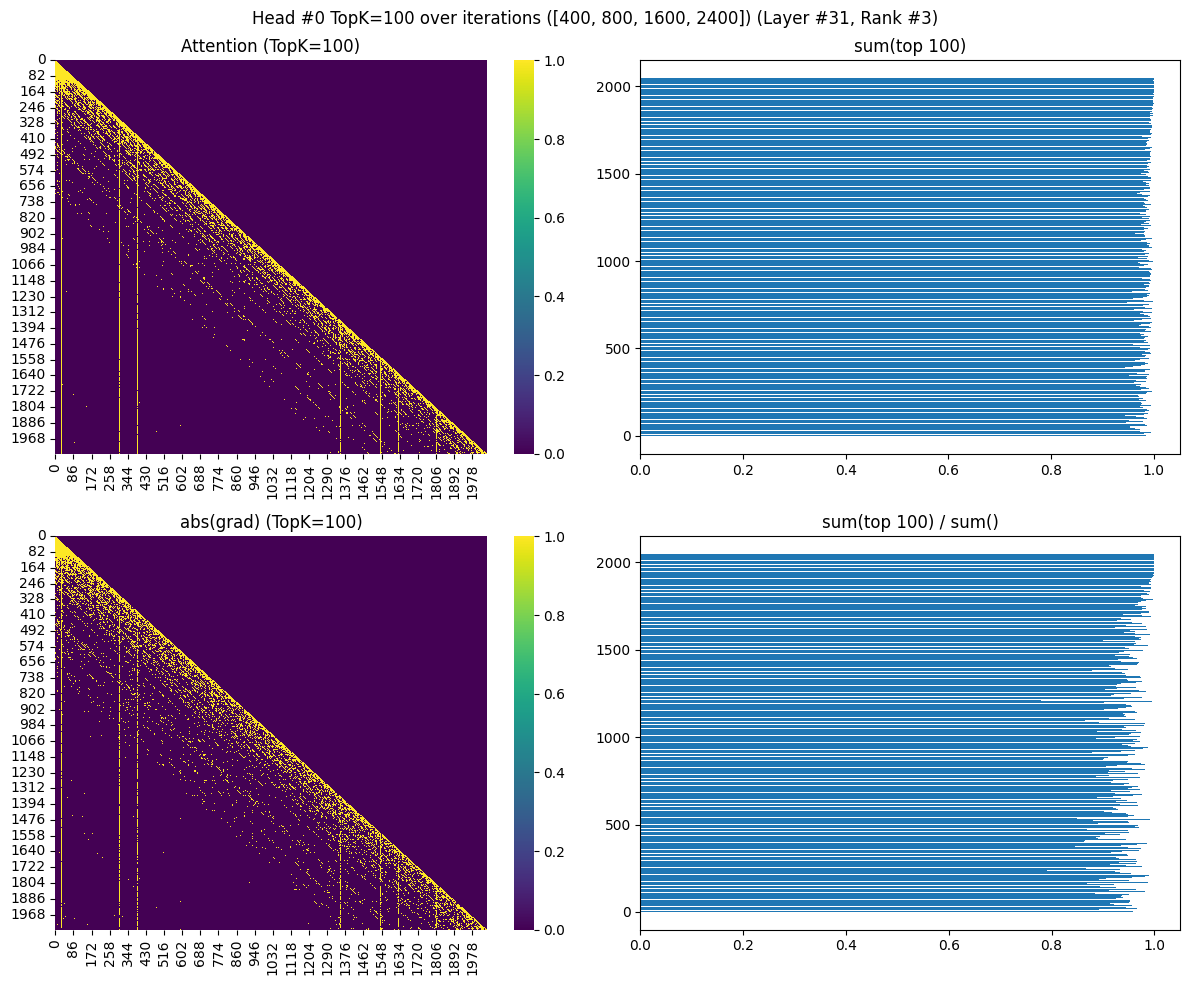

In [31]:
K = 100
V = 0.9
iter_list = [400, 800, 1600, 2400]
layer_idx = 31
head_idx = 0
rank = 3
with_softmax = True
causal = True

num_rows, num_cols = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))


attn_data, grad_data = [], []
for iter_idx in iter_list:
    attn_iter, grad_iter = load_single_data(iter_idx, layer_idx, rank, return_tensor=False)
    attn_iter, grad_iter = attn_iter[head_idx], grad_iter[head_idx]
    attn_iter = torch.from_numpy(attn_iter).to(device)
    grad_iter = torch.from_numpy(grad_iter).to(device)

    if with_softmax:
        grad_iter = grad_softmax(attn_iter, grad_iter)
    
    attn_data.append(attn_iter)
    grad_data.append(grad_iter)
attn_data = torch.stack(attn_data)
grad_data = torch.stack(grad_data)

plot_attn_topk(
    axes, 
    attn_data.mean(dim=0),
    grad_data.mean(dim=0),
    topk=K,
    # topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx} TopK={K} over iterations ({iter_list}) (Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()

(tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [8.0322e-01, 1.9739e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [5.8514e-01, 2.7220e-01, 1.4296e-01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [1.2497e-02, 1.2277e-05, 1.4171e-05,  ..., 5.2368e-02, 0.0000e+00,
          0.0000e+00],
         [1.2081e-02, 6.7731e-05, 5.1515e-05,  ..., 1.8520e-02, 1.0149e-01,
          0.0000e+00],
         [7.5455e-03, 8.1947e-06, 4.0955e-05,  ..., 9.1820e-03, 5.3864e-02,
          4.3042e-01]], device='cuda:0'),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-1.6044e-03,  1.6002e-03,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-9.0969e-04, -1.6733e-03,  2.5487e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 6.6998e-06,  4.3508e-07,  4.0076e

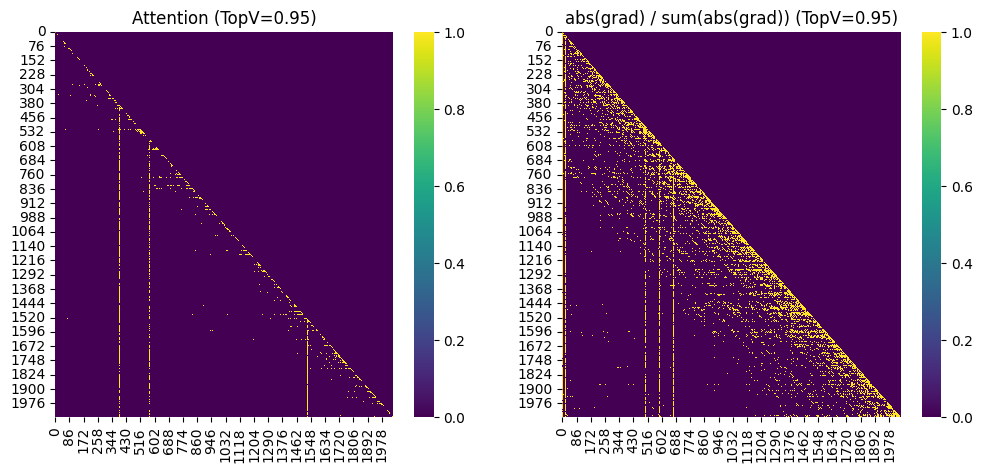

In [11]:
V = 0.95
num_rows, num_cols = 1, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))


plot_attn_topv(
    axes, 
    attn_data.mean(dim=0),
    grad_data.mean(dim=0),
    topv=V,
    causal=True,
)


##### Iter = 400

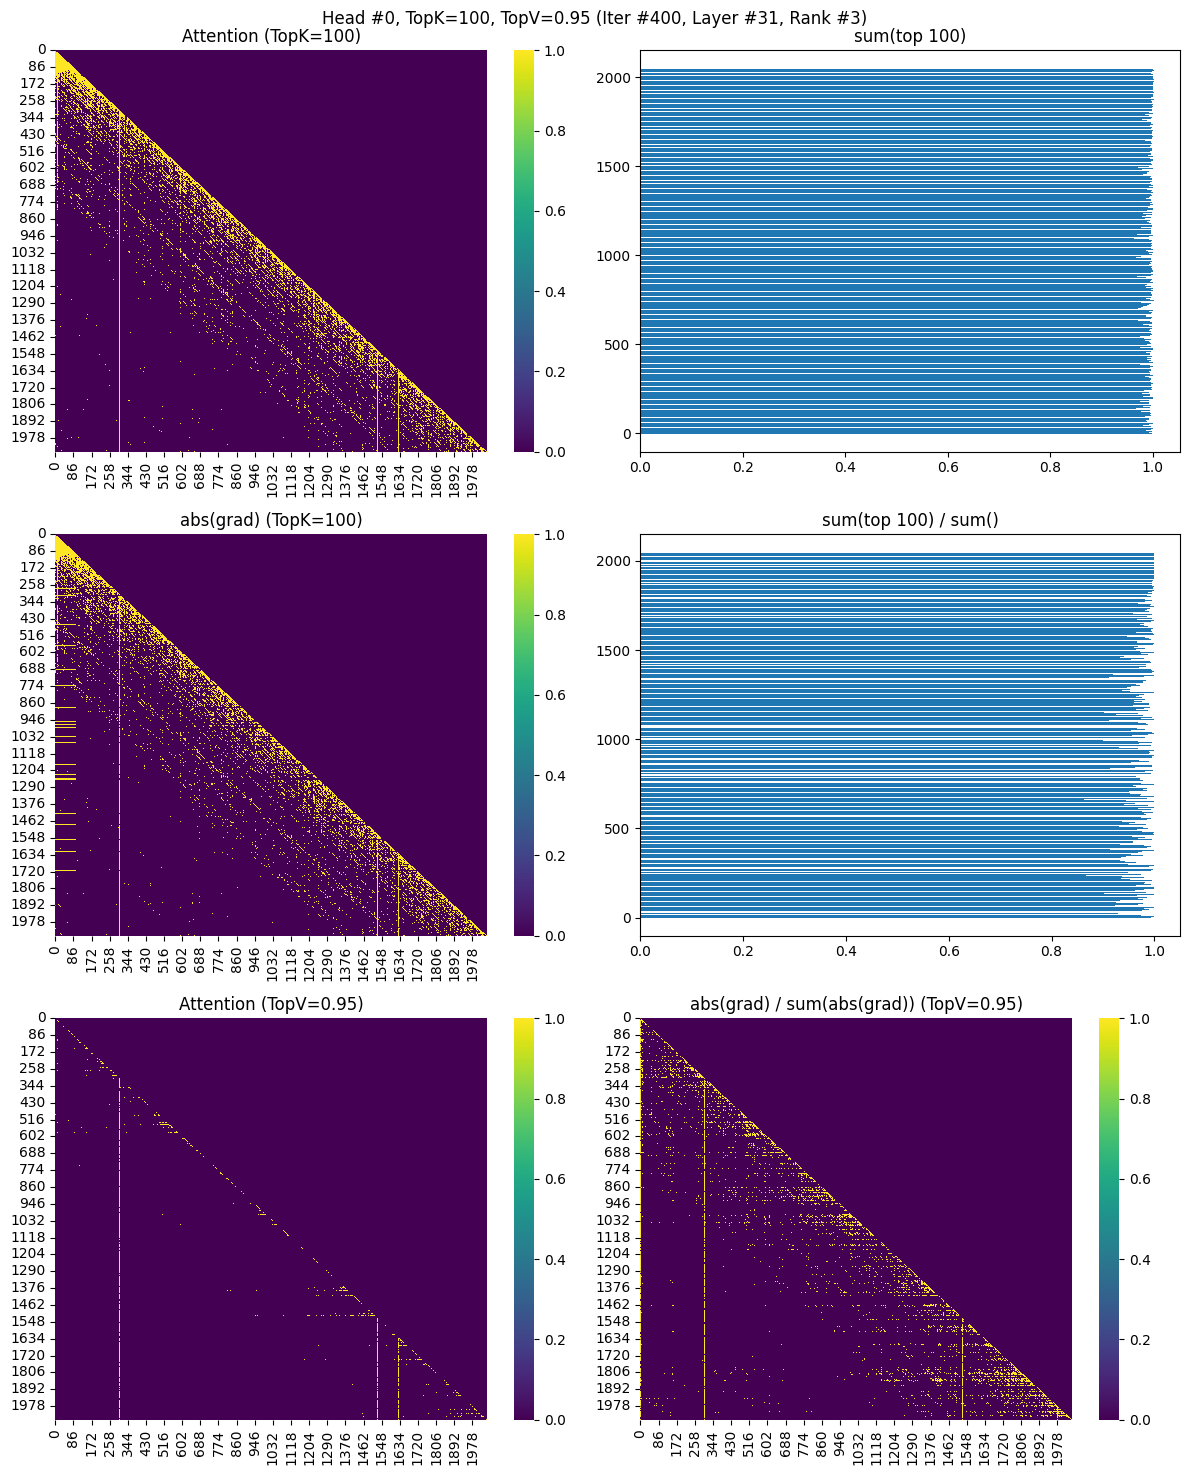

In [15]:
K = 100
V = 0.95
num_rows, num_cols = 3, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    attn_data[0],
    grad_data[0],
    topk=K,
    causal=True,
)

plot_attn_topv(
    axes[2], 
    attn_data[0],
    grad_data[0],
    topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx}, TopK={K}, TopV={V} (Iter #{iter_list[0]}, Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()
plt.show()

In [34]:
grad_data[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.6007e-03,  3.6019e-03,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 7.2697e-03, -1.7307e-03, -5.6548e-03,  ..., -0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        ...,
        [-2.1528e-05,  4.1771e-08,  6.1379e-08,  ...,  1.8621e-03,
          0.0000e+00,  0.0000e+00],
        [-2.7109e-04,  1.6196e-07, -4.7810e-08,  ...,  6.1365e-04,
          1.6879e-02, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')

(array([7.000000e+00, 9.000000e+00, 2.500000e+01, 5.400000e+01,
        2.126000e+03, 4.191956e+06, 8.700000e+01, 2.300000e+01,
        1.000000e+01, 7.000000e+00]),
 array([-0.07270338, -0.0582965 , -0.04388963, -0.02948275, -0.01507588,
        -0.00066901,  0.01373787,  0.02814474,  0.04255161,  0.05695849,
         0.07136536]),
 <BarContainer object of 10 artists>)

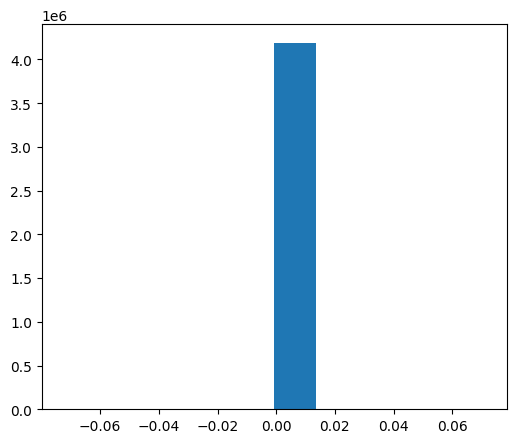

In [33]:
# plot normal histogram over attn_data[iter_list_idx]
num_rows, num_cols = 1, 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plt.hist(
    grad_data[0].cpu().numpy().flatten(), 
    # range=(0, 1), bins=100
)

Text(0.5, 1.0, 'Histogram of Row-wise Cosine Similarity between Attention and Gradient (abs)')

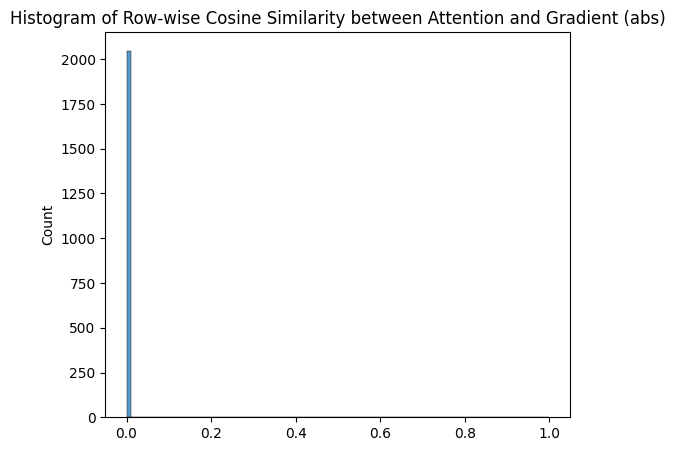

In [23]:
iter_list_idx = 0
num_rows, num_cols = 1, 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))
plot_sim_hist(
    axes, 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    range=(0, 1),
    causal=causal,
)
axes.set_title('Histogram of Row-wise Cosine Similarity between Attention and Gradient (abs)')

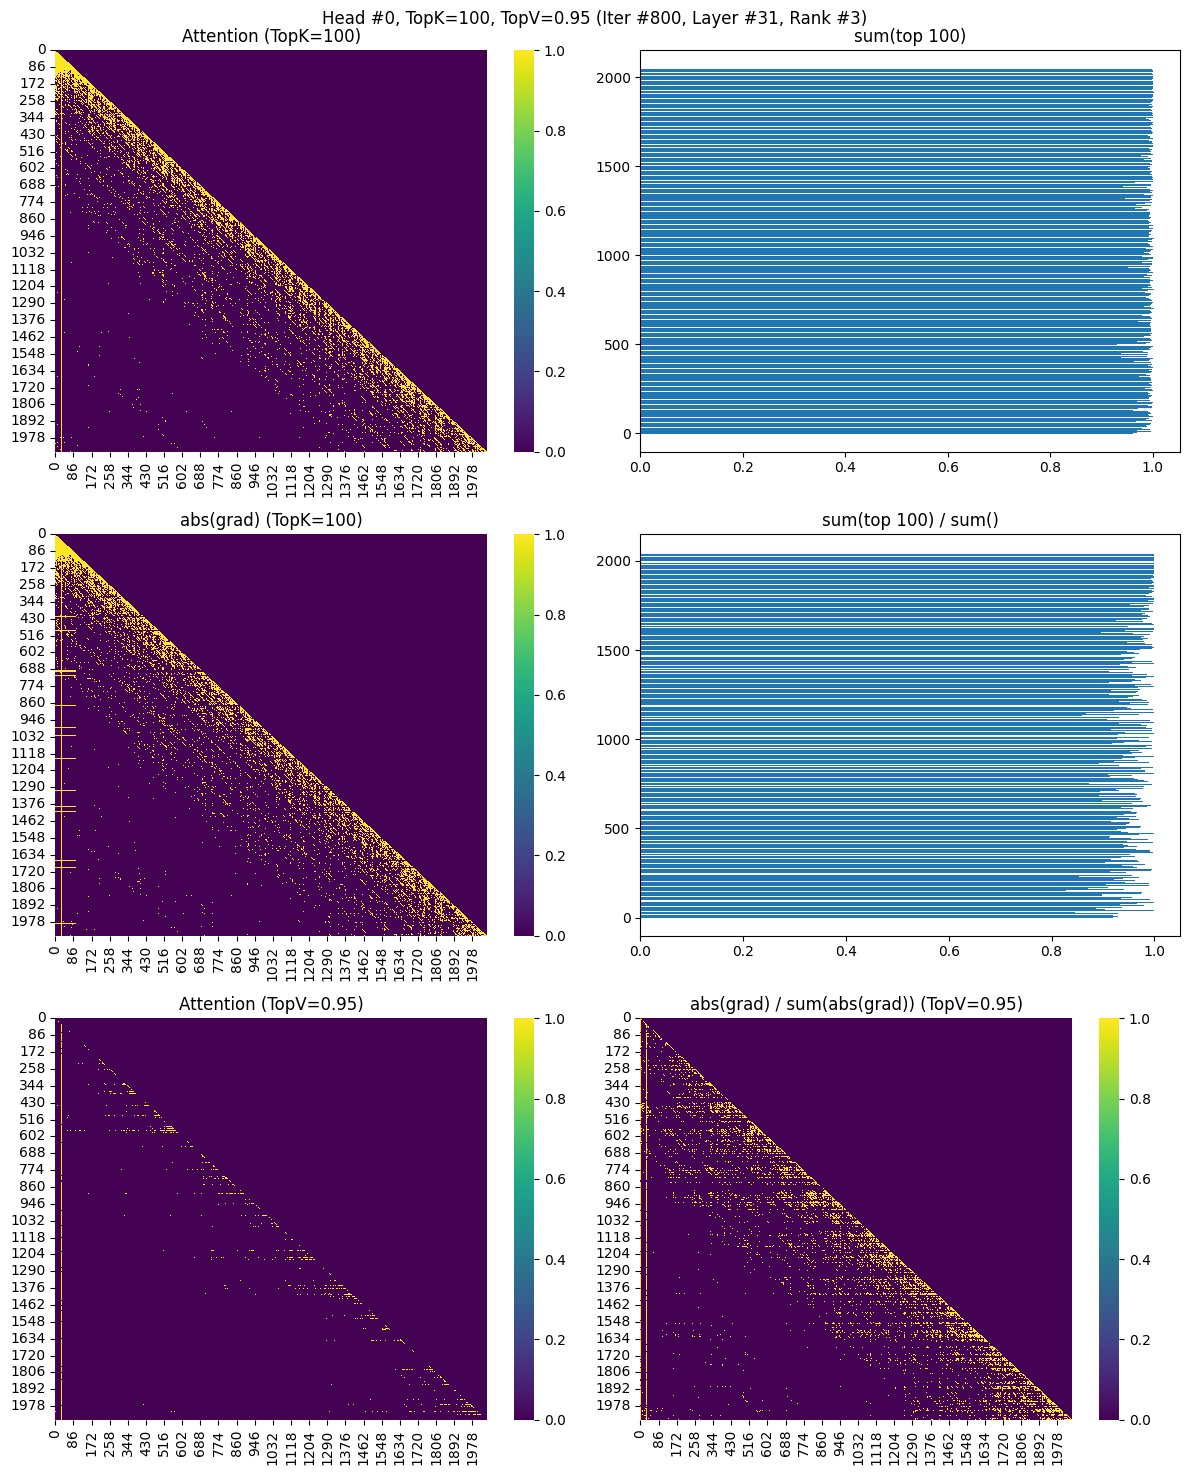

In [12]:
K = 100
V = 0.95
iter_list_idx = 1
num_rows, num_cols = 3, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topk=K,
    causal=True,
)

plot_attn_topv(
    axes[2], 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx}, TopK={K}, TopV={V} (Iter #{iter_list[iter_list_idx]}, Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()
plt.show()

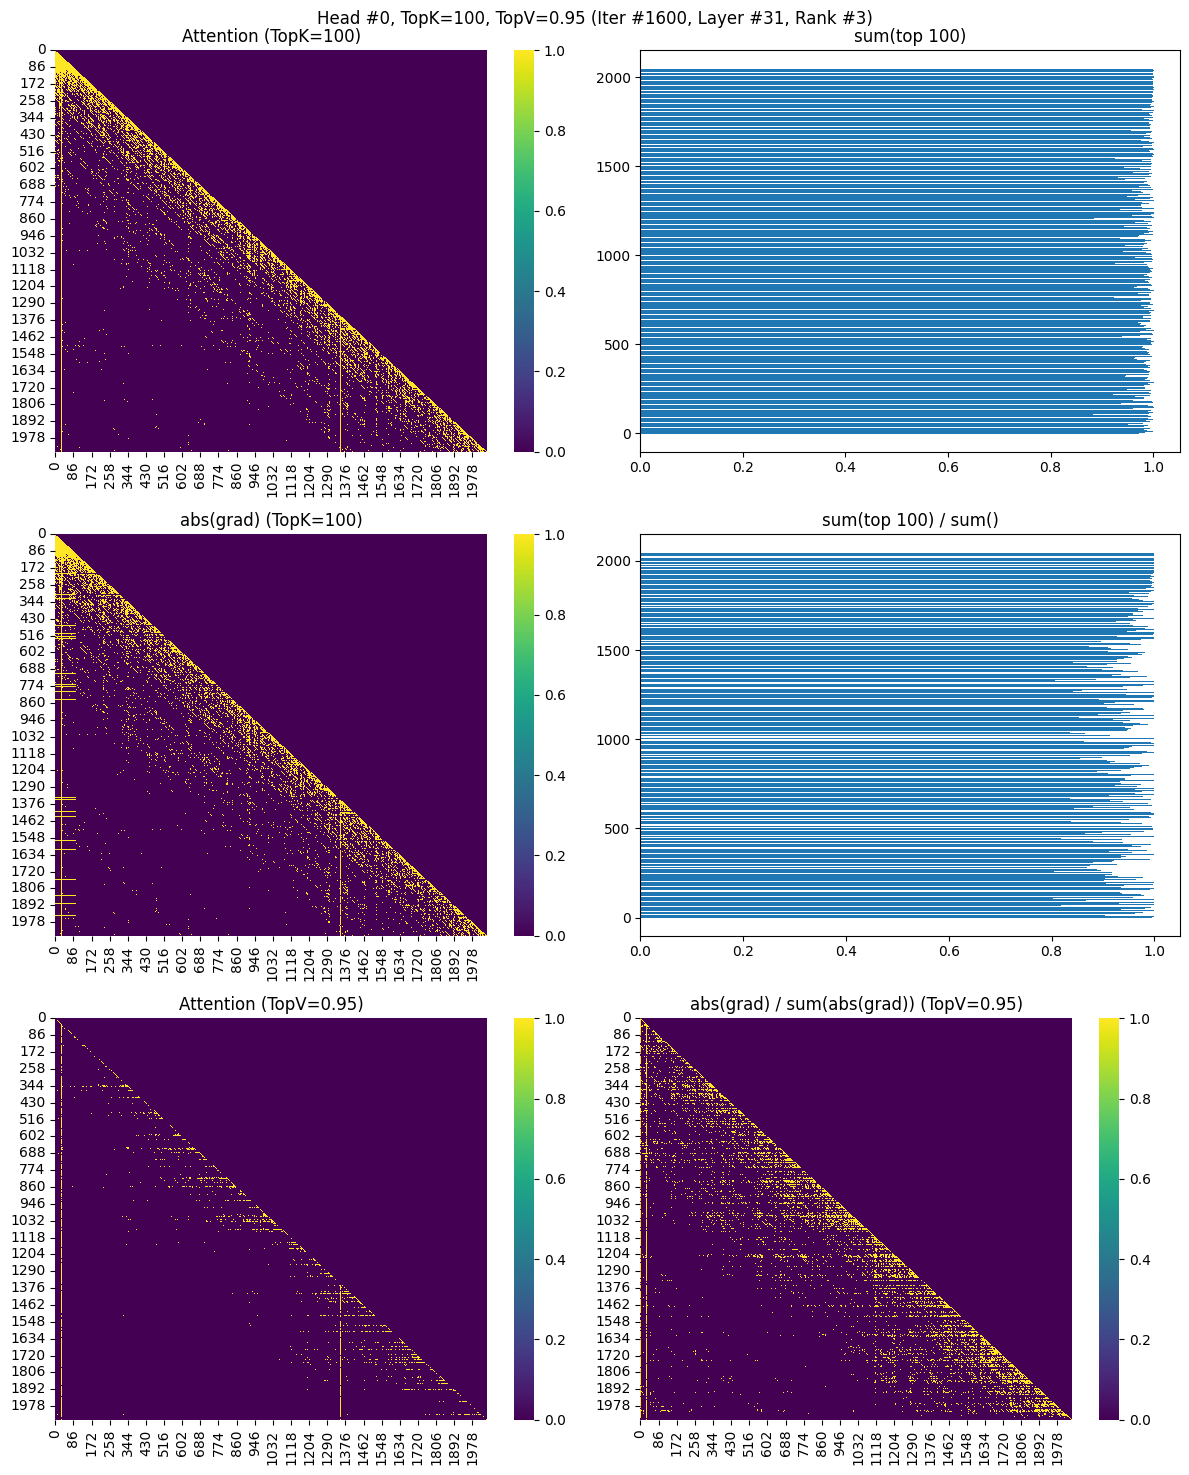

In [13]:
K = 100
V = 0.95
iter_list_idx = 2
num_rows, num_cols = 3, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topk=K,
    causal=True,
)

plot_attn_topv(
    axes[2], 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx}, TopK={K}, TopV={V} (Iter #{iter_list[iter_list_idx]}, Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()
plt.show()

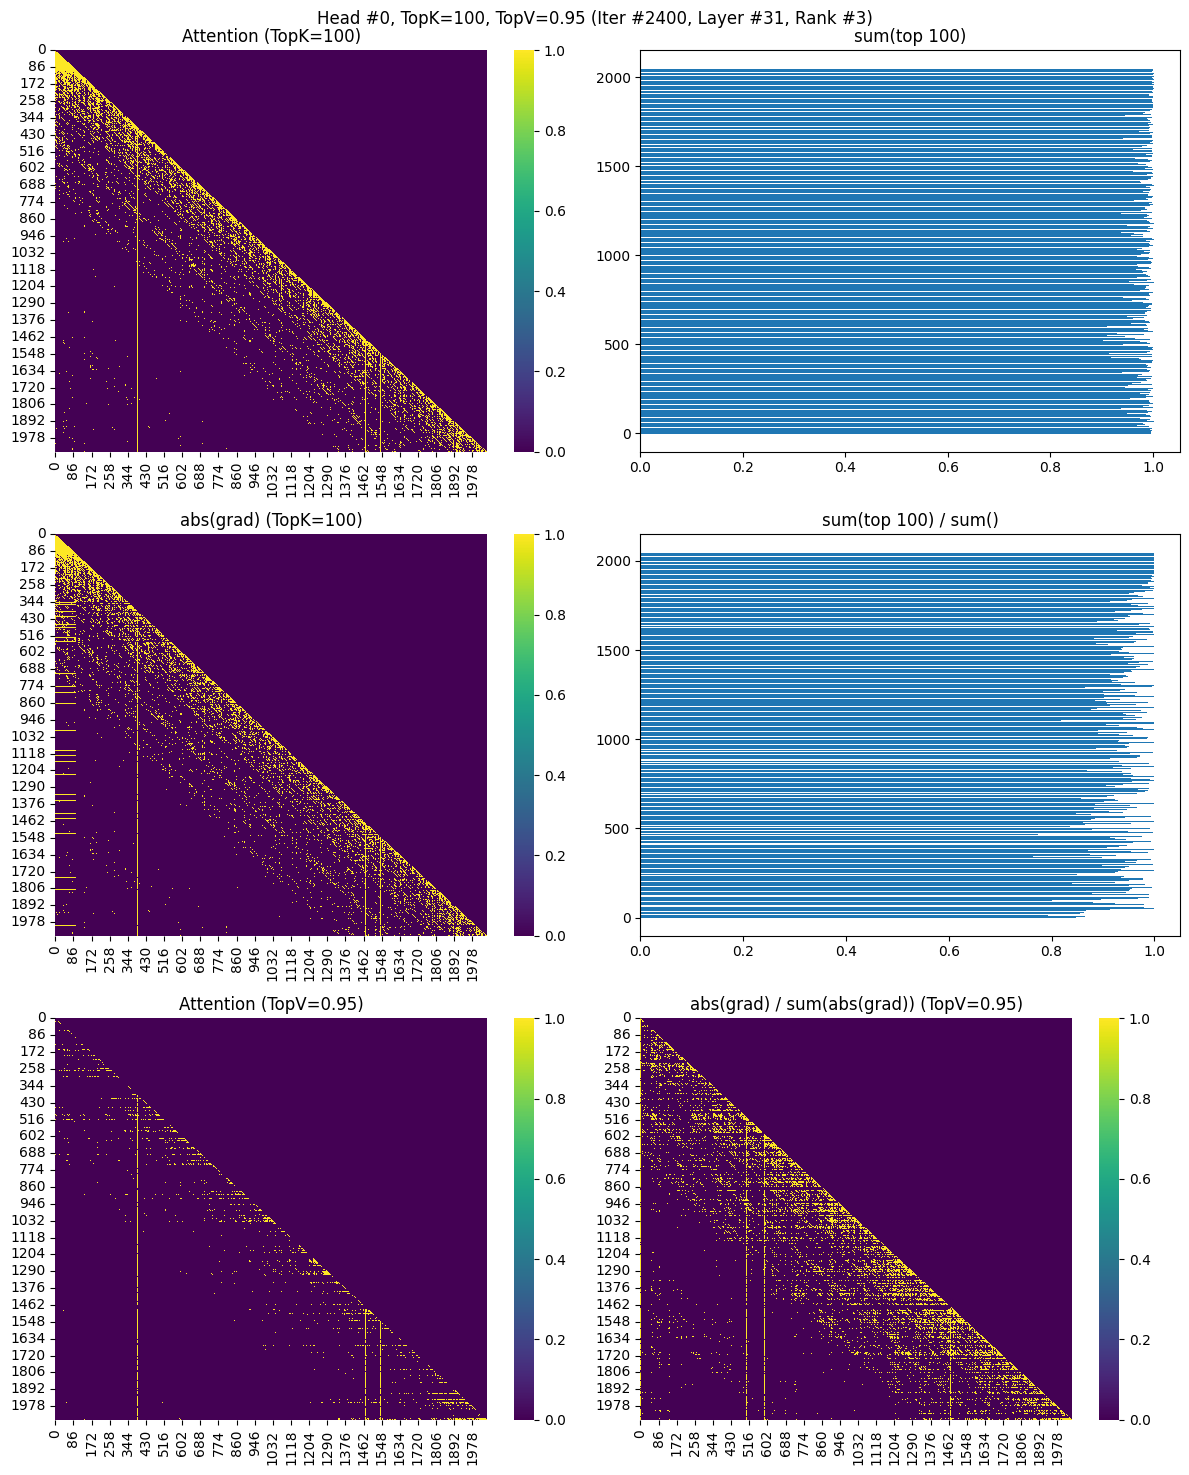

In [14]:
K = 100
V = 0.95
iter_list_idx = 3
num_rows, num_cols = 3, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topk=K,
    causal=True,
)

plot_attn_topv(
    axes[2], 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx}, TopK={K}, TopV={V} (Iter #{iter_list[iter_list_idx]}, Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()
plt.show()

#### Head = 2, Layer = 16

--------------------------------------------------------------------------------
Loading data for iteration 400
--------------------------------------------------------------------------------
Loading data for iteration 800
--------------------------------------------------------------------------------
Loading data for iteration 1600
--------------------------------------------------------------------------------
Loading data for iteration 2400


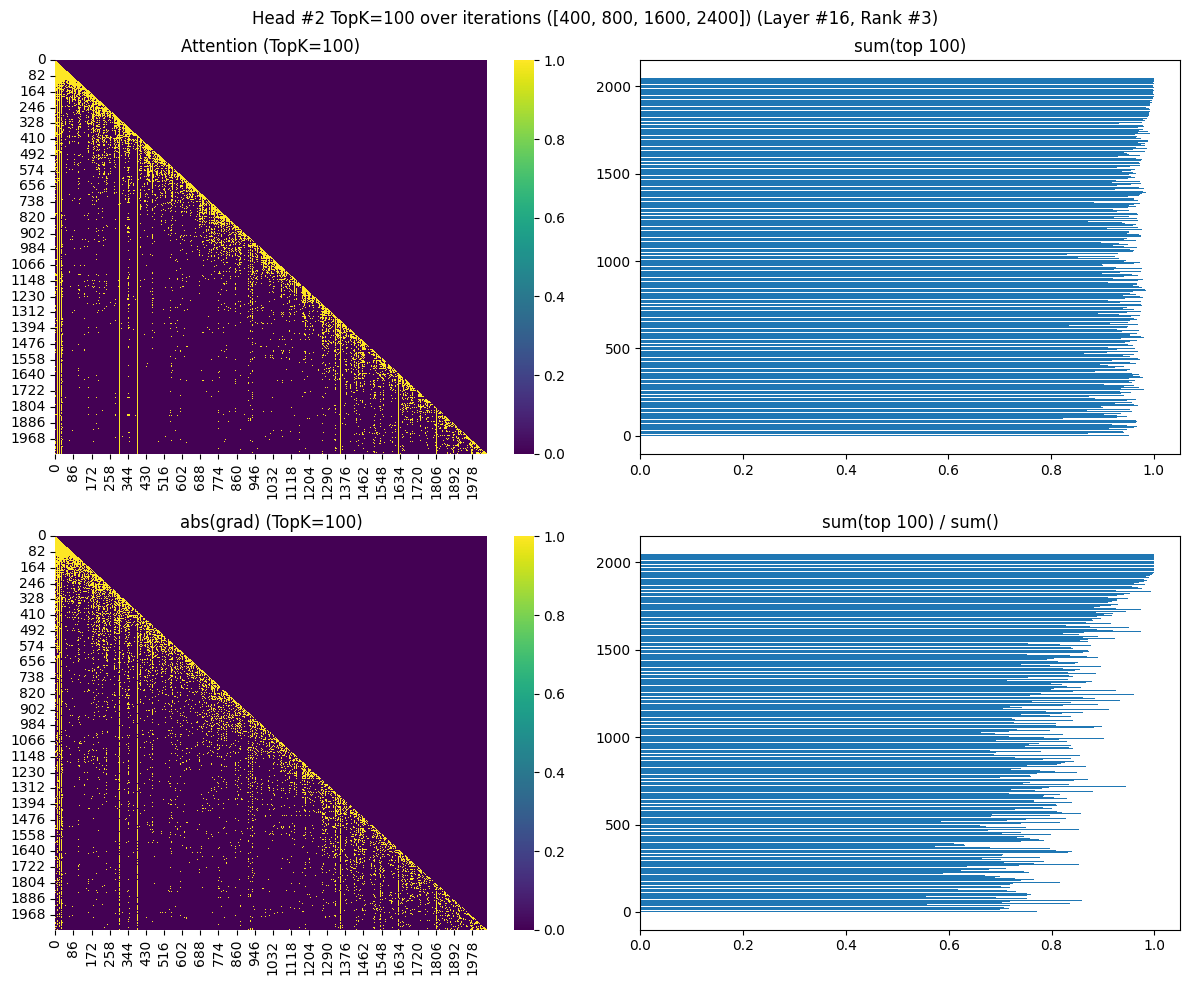

In [16]:
K = 100
V = 0.9
iter_list = [400, 800, 1600, 2400]
layer_idx = 16
head_idx = 2
rank = 3
with_softmax = True
causal = True

num_rows, num_cols = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))


attn_data, grad_data = [], []
for iter_idx in iter_list:
    attn_iter, grad_iter = load_single_data(iter_idx, layer_idx, rank, return_tensor=False)
    attn_iter, grad_iter = attn_iter[head_idx], grad_iter[head_idx]
    attn_iter = torch.from_numpy(attn_iter).to(device)
    grad_iter = torch.from_numpy(grad_iter).to(device)

    if with_softmax:
        grad_iter = grad_softmax(attn_iter, grad_iter)
    
    attn_data.append(attn_iter)
    grad_data.append(grad_iter)
attn_data = torch.stack(attn_data)
grad_data = torch.stack(grad_data)

plot_attn_topk(
    axes, 
    attn_data.mean(dim=0),
    grad_data.mean(dim=0),
    topk=K,
    # topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx} TopK={K} over iterations ({iter_list}) (Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()

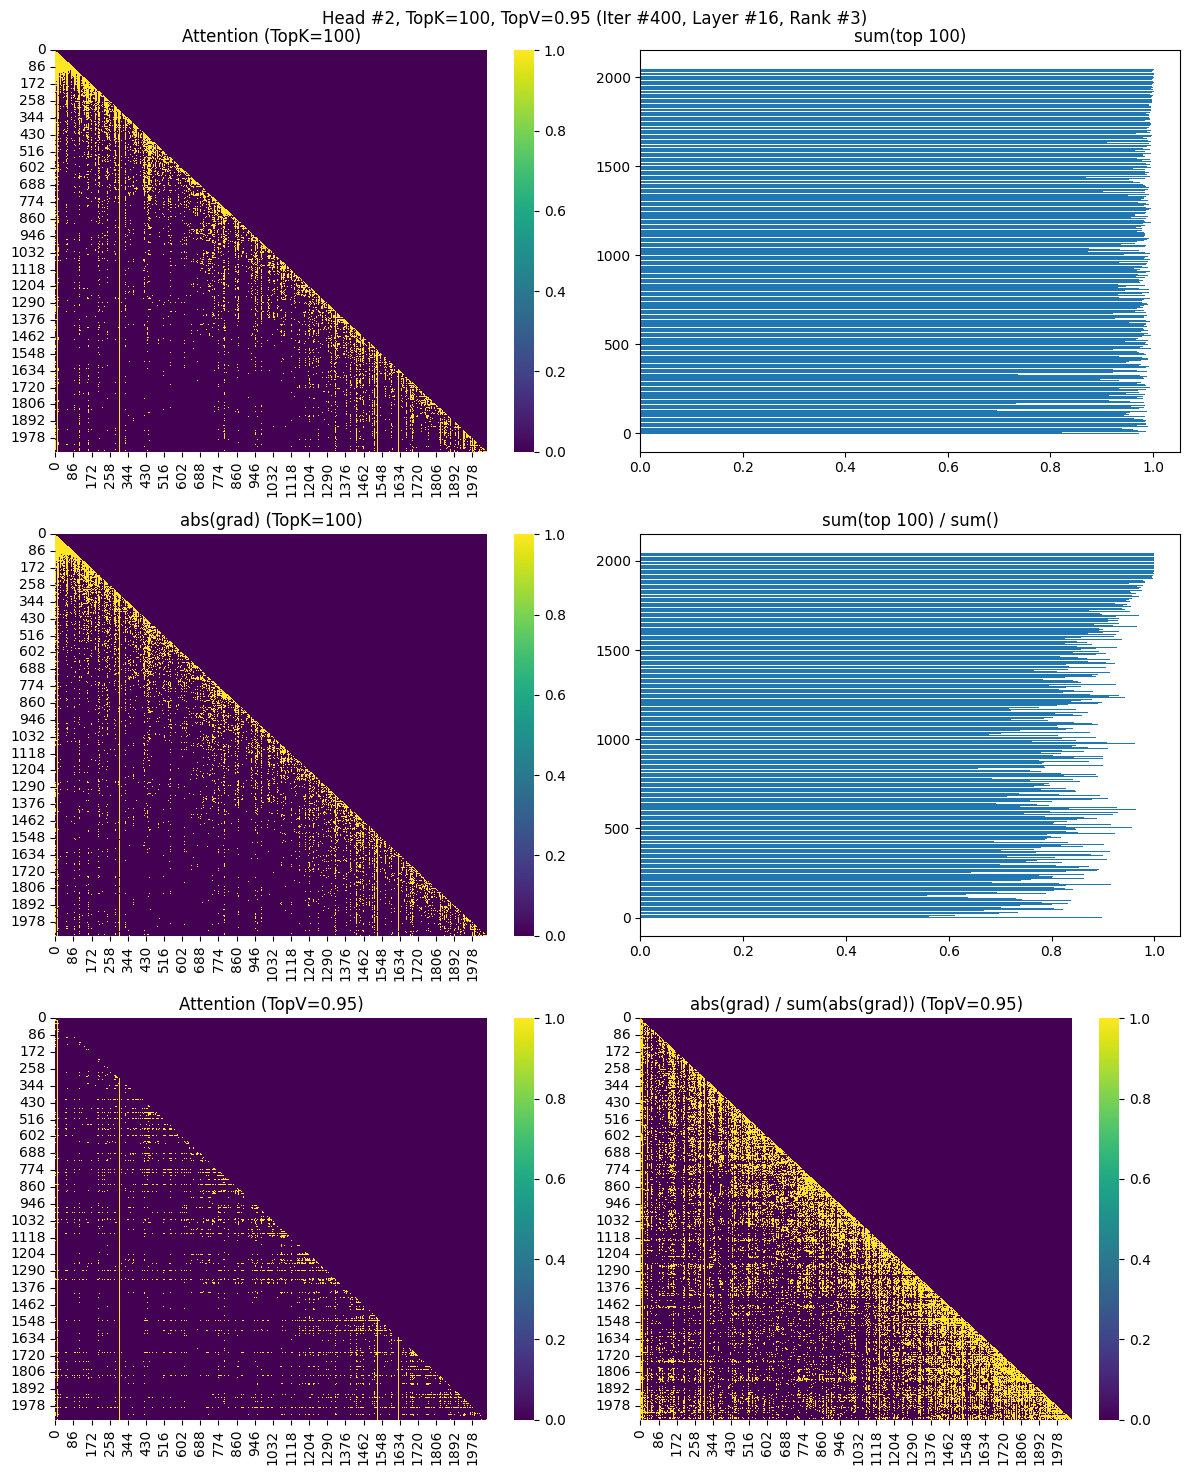

In [17]:
K = 100
V = 0.95
iter_list_idx = 0
num_rows, num_cols = 3, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topk=K,
    causal=True,
)

plot_attn_topv(
    axes[2], 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx}, TopK={K}, TopV={V} (Iter #{iter_list[iter_list_idx]}, Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()
plt.show()

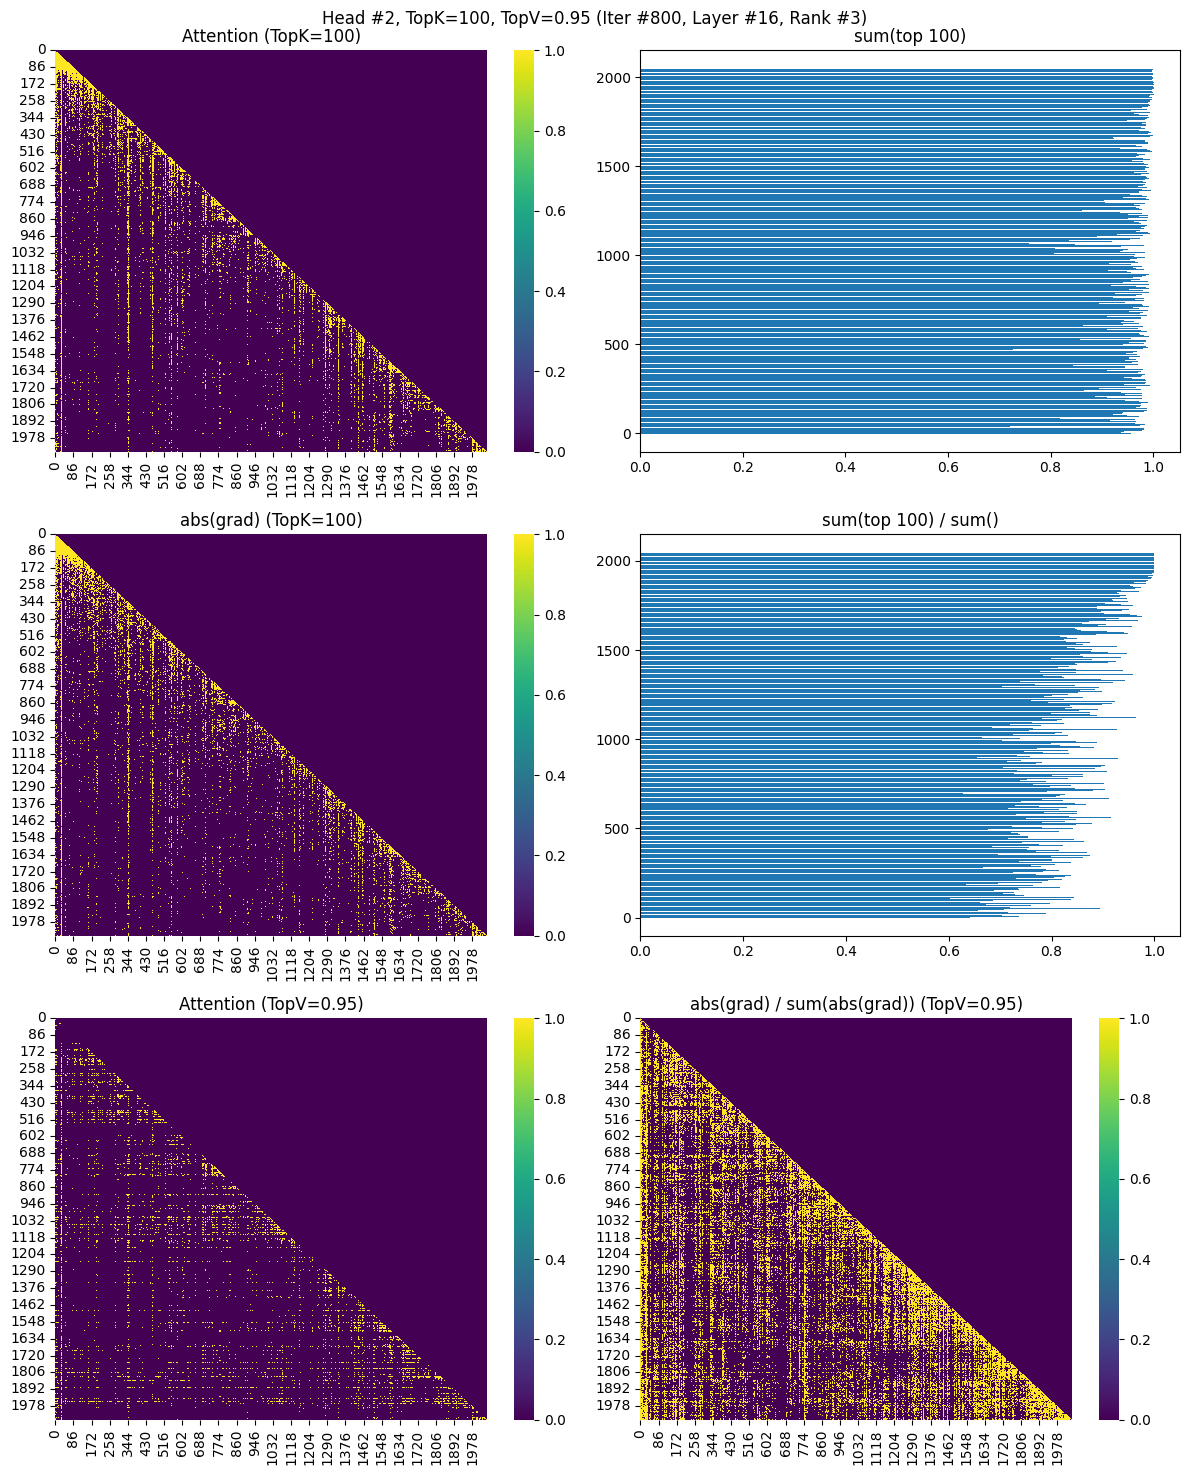

In [18]:
K = 100
V = 0.95
iter_list_idx = 1
num_rows, num_cols = 3, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topk=K,
    causal=True,
)

plot_attn_topv(
    axes[2], 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx}, TopK={K}, TopV={V} (Iter #{iter_list[iter_list_idx]}, Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()
plt.show()

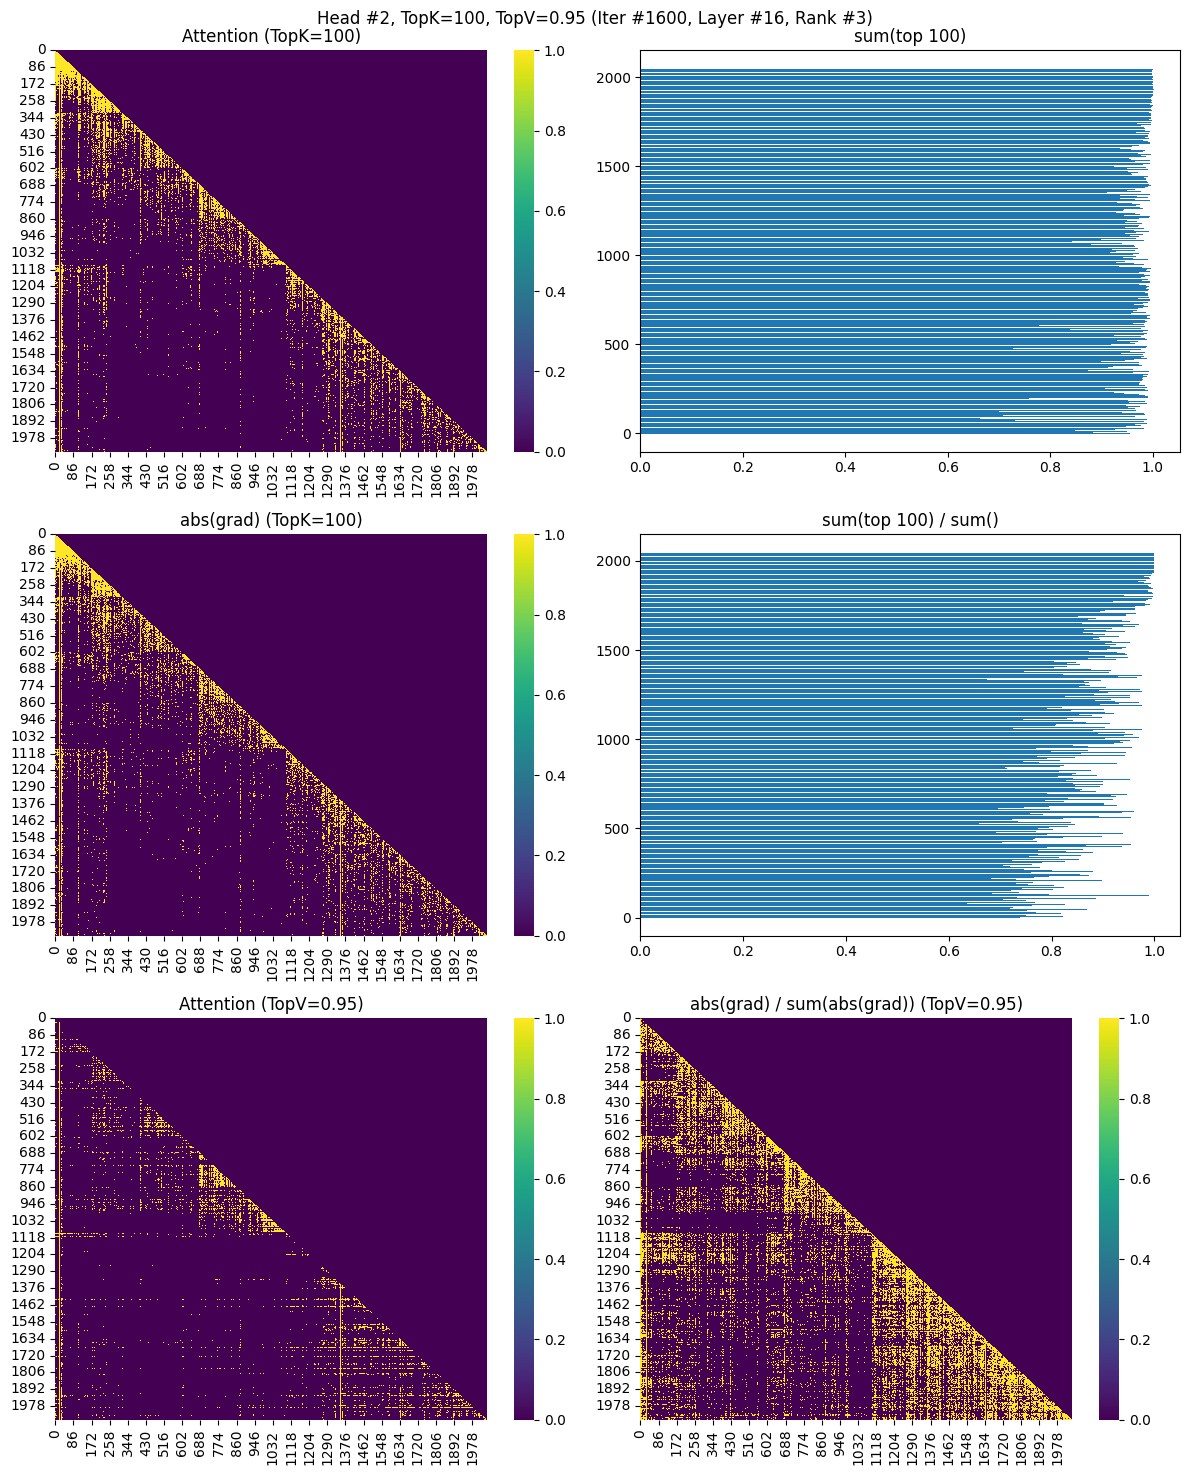

In [19]:
K = 100
V = 0.95
iter_list_idx = 2
num_rows, num_cols = 3, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topk=K,
    causal=True,
)

plot_attn_topv(
    axes[2], 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx}, TopK={K}, TopV={V} (Iter #{iter_list[iter_list_idx]}, Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()
plt.show()

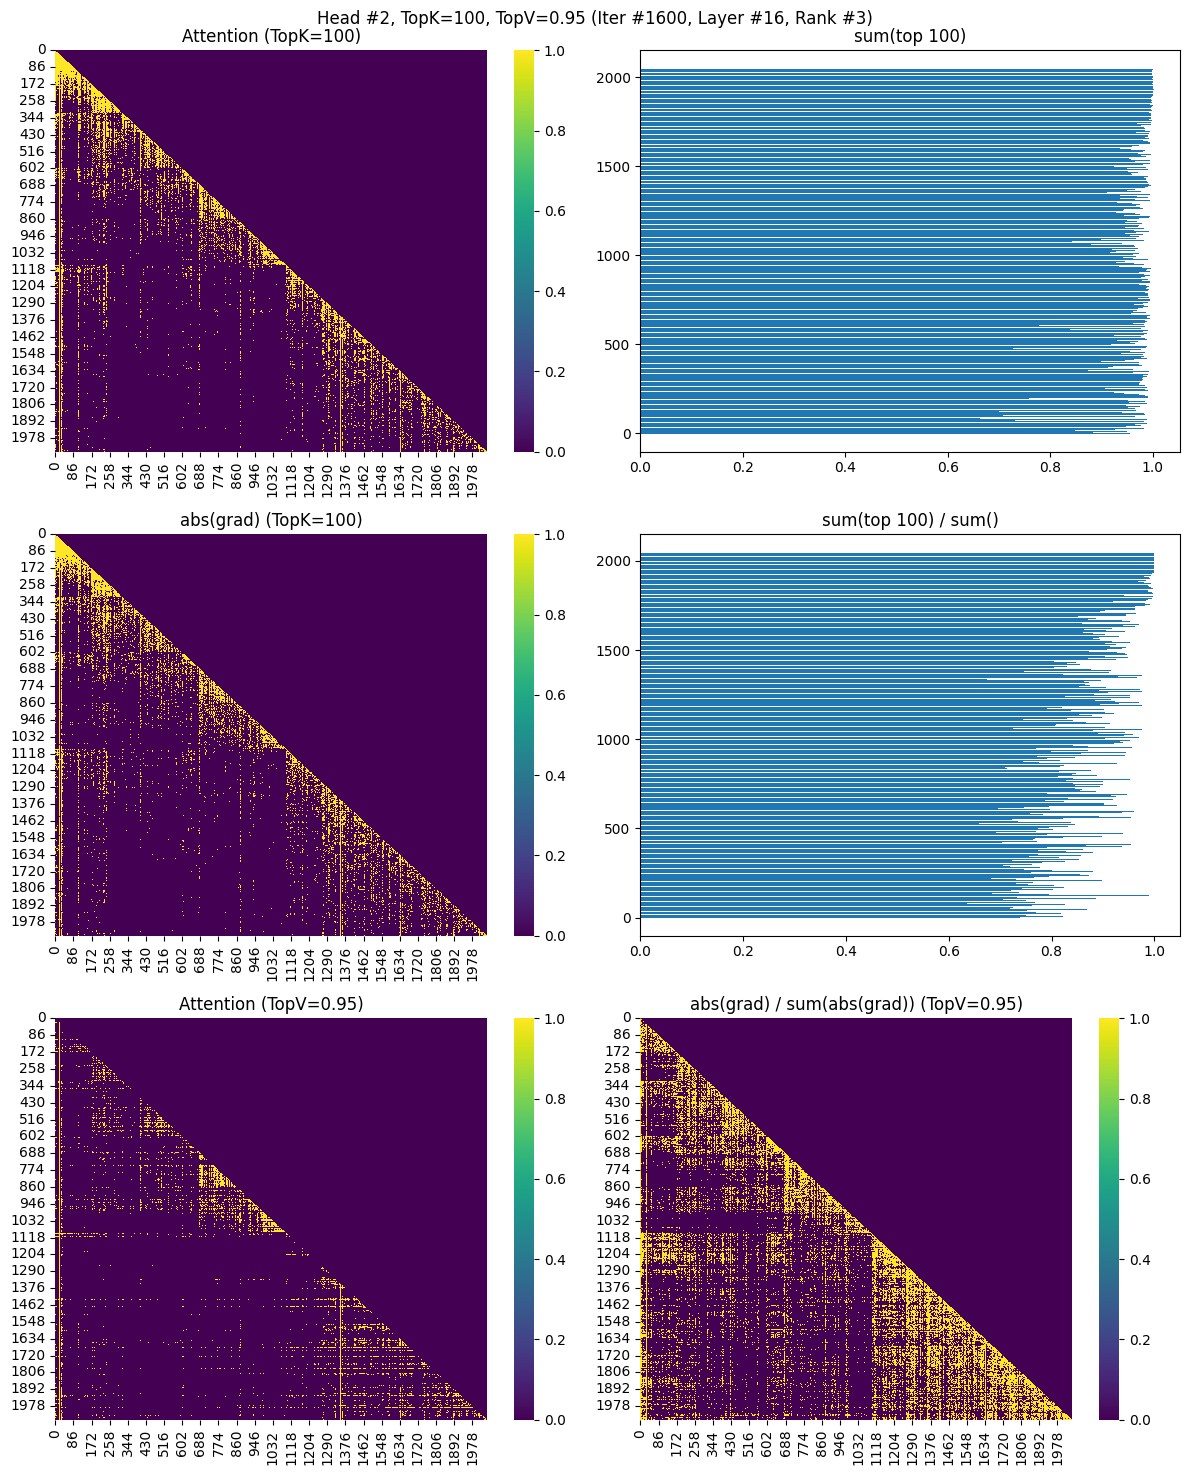

In [21]:
K = 100
V = 0.95
iter_list_idx = 2
num_rows, num_cols = 3, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topk=K,
    causal=True,
)

plot_attn_topv(
    axes[2], 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx}, TopK={K}, TopV={V} (Iter #{iter_list[iter_list_idx]}, Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()
plt.show()

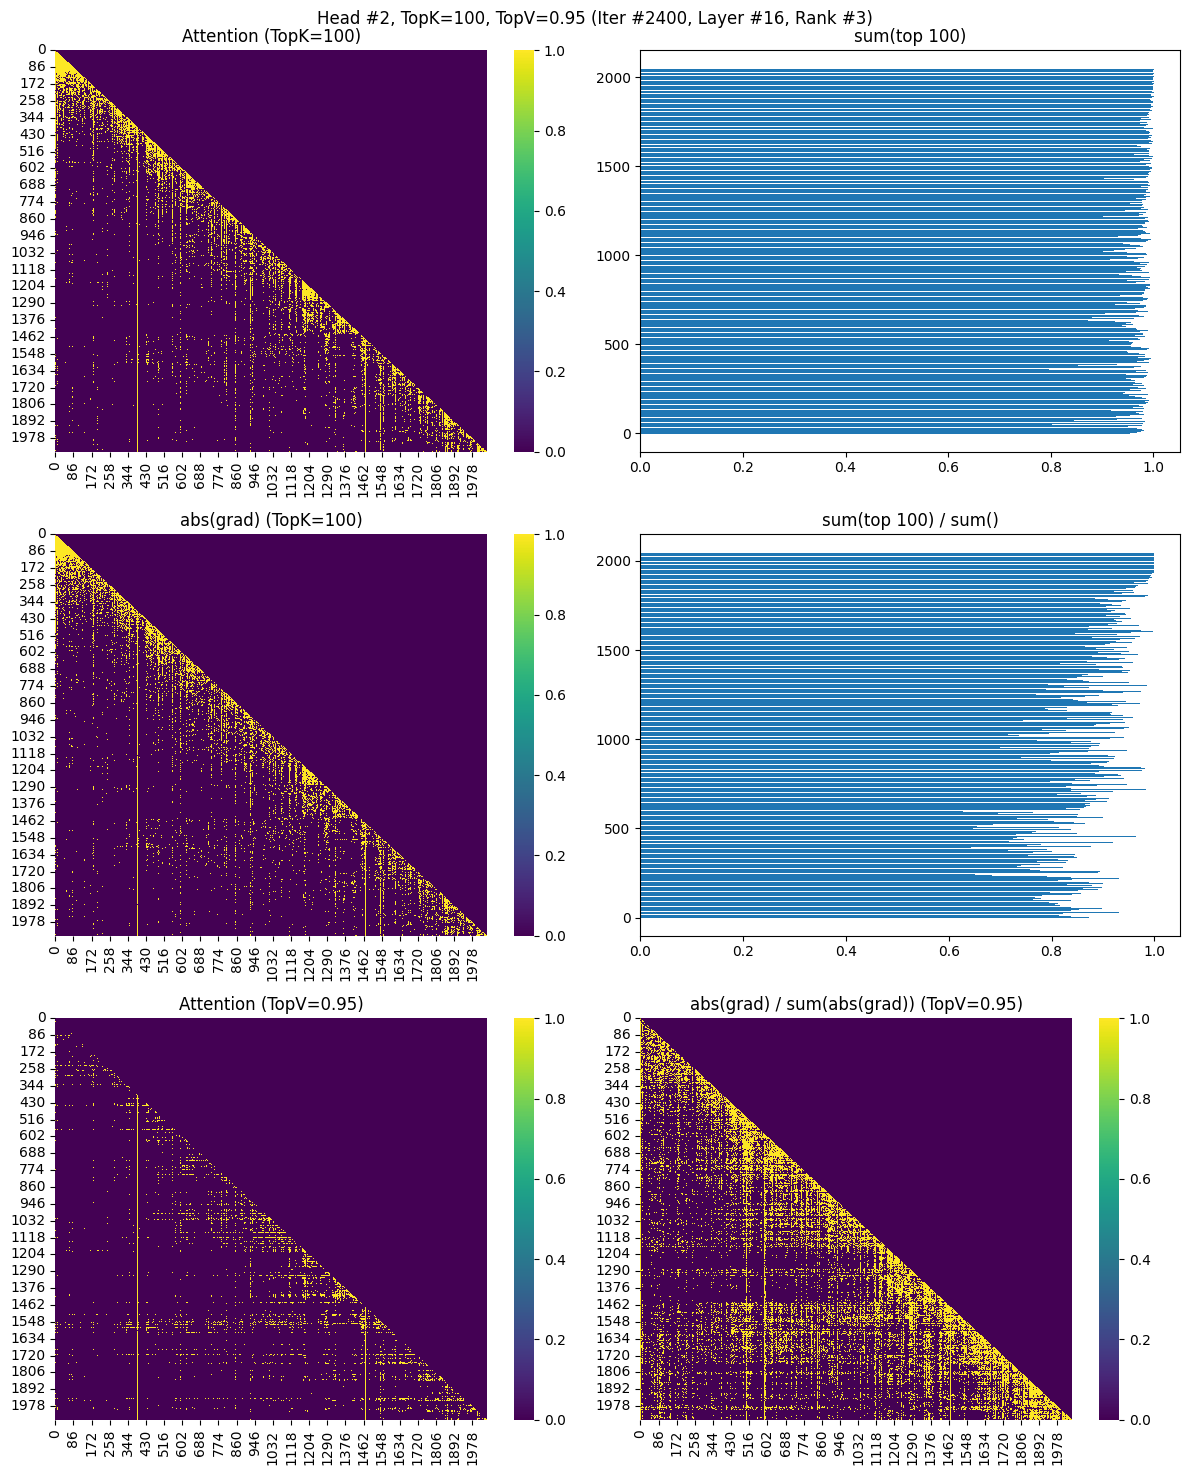

In [20]:
K = 100
V = 0.95
iter_list_idx = 3
num_rows, num_cols = 3, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topk=K,
    causal=True,
)

plot_attn_topv(
    axes[2], 
    attn_data[iter_list_idx],
    grad_data[iter_list_idx],
    topv=V,
    causal=True,
)

plt.suptitle(f'Head #{head_idx}, TopK={K}, TopV={V} (Iter #{iter_list[iter_list_idx]}, Layer #{layer_idx}, Rank #{rank})')
plt.tight_layout()
plt.show()

### By Layer (Average)

--------------------------------------------------------------------------------
Loading data for iteration 800


(tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [5.9142e-01, 4.0869e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [3.0836e-01, 3.5732e-01, 3.3451e-01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [1.0835e-04, 9.8919e-05, 2.2561e-04,  ..., 2.7596e-02, 0.0000e+00,
          0.0000e+00],
         [1.1904e-04, 9.0234e-05, 1.6779e-04,  ..., 4.8539e-02, 4.2782e-02,
          0.0000e+00],
         [1.6129e-04, 9.1854e-05, 1.2984e-04,  ..., 2.1865e-02, 9.5675e-02,
          2.5129e-02]], device='cuda:0'),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 3.0221e-03, -3.0214e-03,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-7.8014e-04, -7.9079e-03,  8.6864e-03,  ...,  0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         ...,
         [-4.5922e-07,  1.0718e-07,  1.2787e

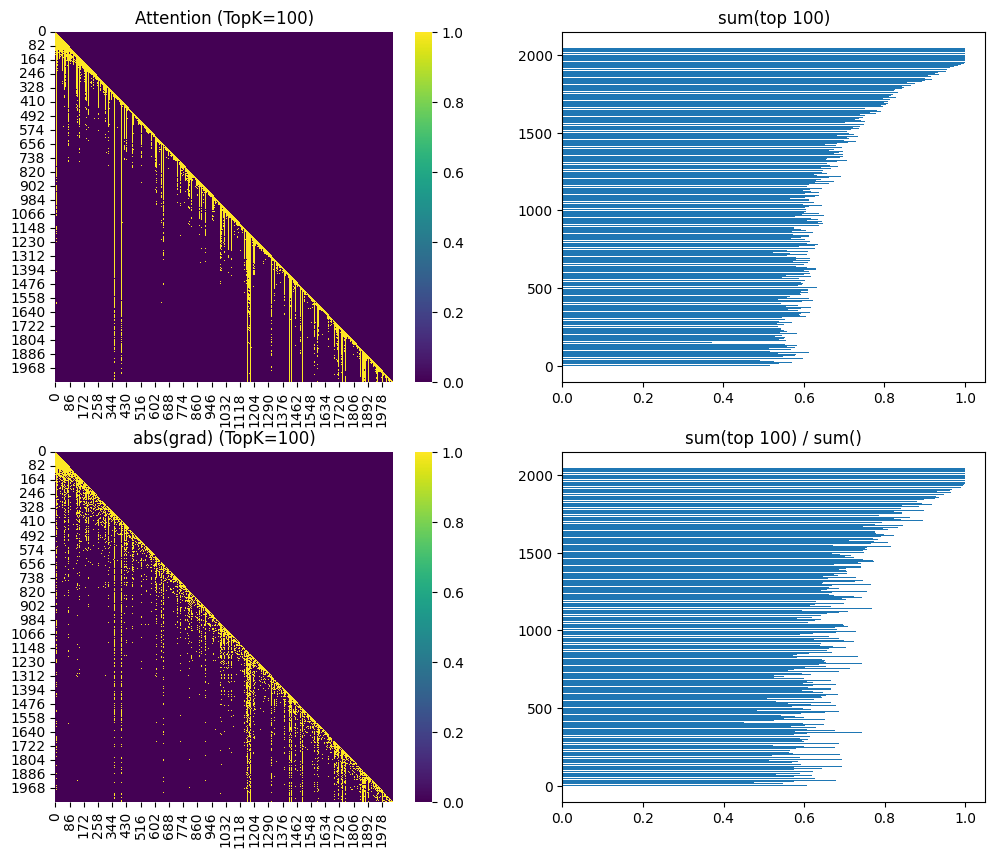

In [40]:
K = 100
iter_idx = 800
layer_idx = 1
head_idx = None
rank = 3
with_softmax = True
causal = True

num_rows, num_cols = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

attn_data, grad_data = load_single_data(iter_idx, layer_idx, rank, return_tensor=True)
attn_data, grad_data = attn_data.mean(dim=0), grad_data.mean(dim=0)
with torch.no_grad():
    if with_softmax:
        grad_data = grad_softmax(attn_data, grad_data)

plot_attn_topk(
    axes, 
    attn_data,
    grad_data,
    topk=K,
    # topv=V,
    causal=True,
)


#### Layer 31

--------------------------------------------------------------------------------
Loading data for iteration 800


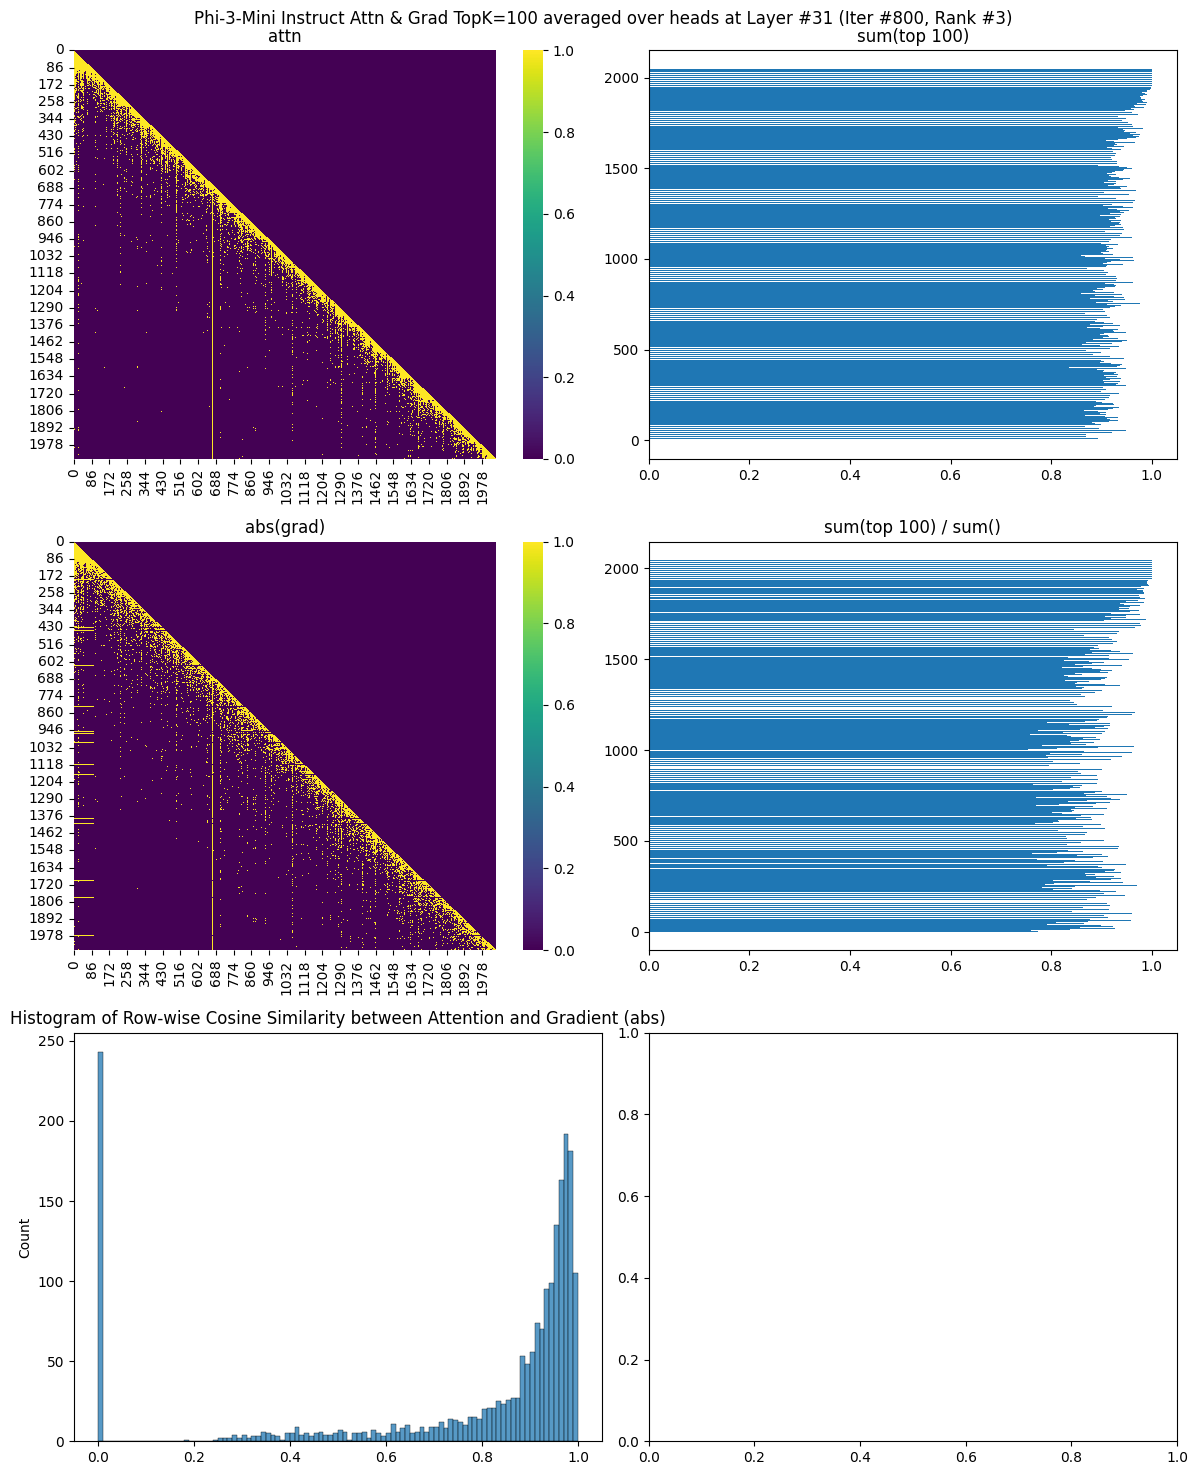

In [72]:
K = 100
iter_idx = 800
layer_idx = 31
head_idx = None
rank = 3
with_softmax = True
causal = True

num_rows, num_cols = 3, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

attn_data, grad_data = load_single_data(iter_idx, layer_idx, rank)
if head_idx:
    attn_data, grad_data = attn_data[head_idx], grad_data[head_idx]
else:
    # Average over all heads
    attn_data, grad_data = attn_data.mean(dim=0), grad_data.mean(dim=0)
if with_softmax:
    grad_data = grad_softmax(attn_data, grad_data)

plot_attn_topk(
    axes, 
    attn_data,
    grad_data,
    topk=K,
    causal=True,
)

plot_sim_hist(
    axes[2][0], 
    attn_data, 
    grad_data,
    # bins=100,
    range=(0, 1),
    causal=causal,
)
axes[2][0].set_title('Histogram of Row-wise Cosine Similarity between Attention and Gradient (abs)')

if head_idx:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} (Iter #{iter_idx}, Layer #{layer_idx}, Head #{head_idx}, Rank #{rank})')
else:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} averaged over heads at Layer #{layer_idx} (Iter #{iter_idx}, Rank #{rank})')

plt.tight_layout()

--------------------------------------------------------------------------------
Loading data for iteration 800


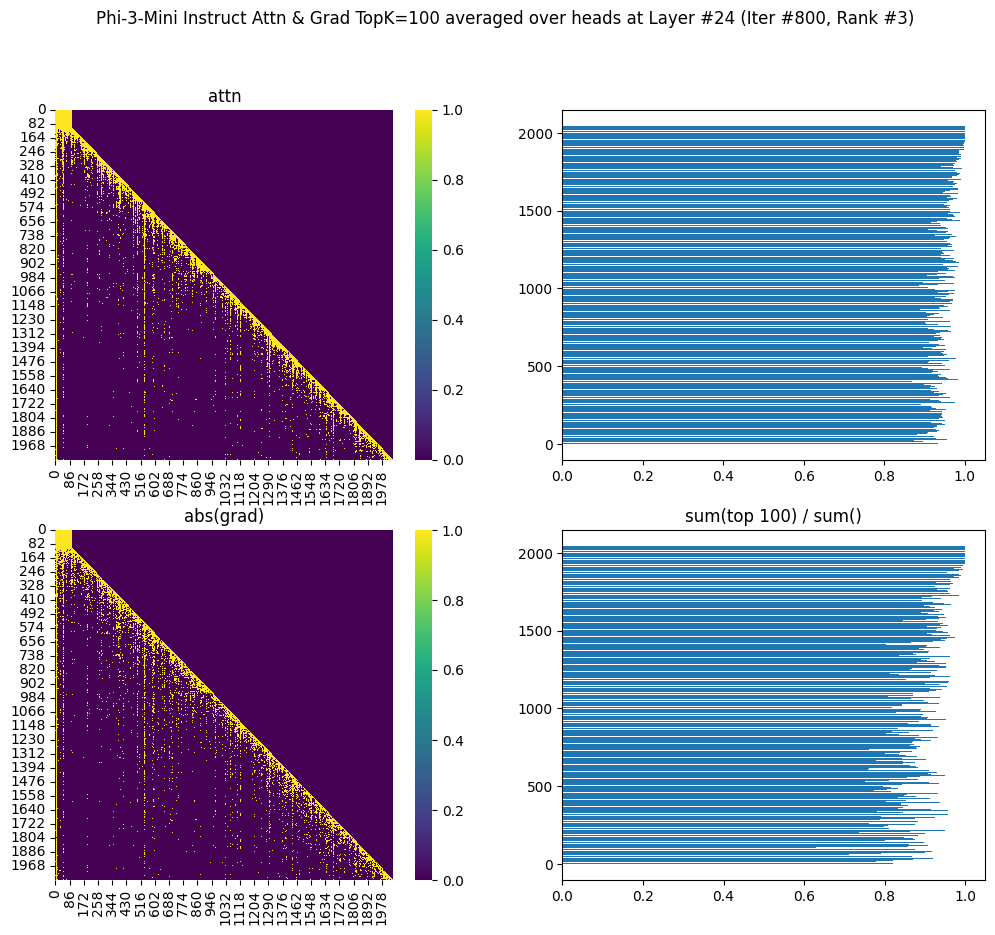

In [46]:
K = 100
iter_idx = 800
layer_idx = 24
head_idx = None
rank = 3


num_rows, num_cols = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    iter_idx=iter_idx, 
    layer_idx=layer_idx, 
    rank=rank, 
    head_idx=head_idx, 
    topk=K,
    causal=False,
)

if head_idx:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} (Iter #{iter_idx}, Layer #{layer_idx}, Head #{head_idx}, Rank #{rank})')
else:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} averaged over heads at Layer #{layer_idx} (Iter #{iter_idx}, Rank #{rank})')

--------------------------------------------------------------------------------
Loading data for iteration 800


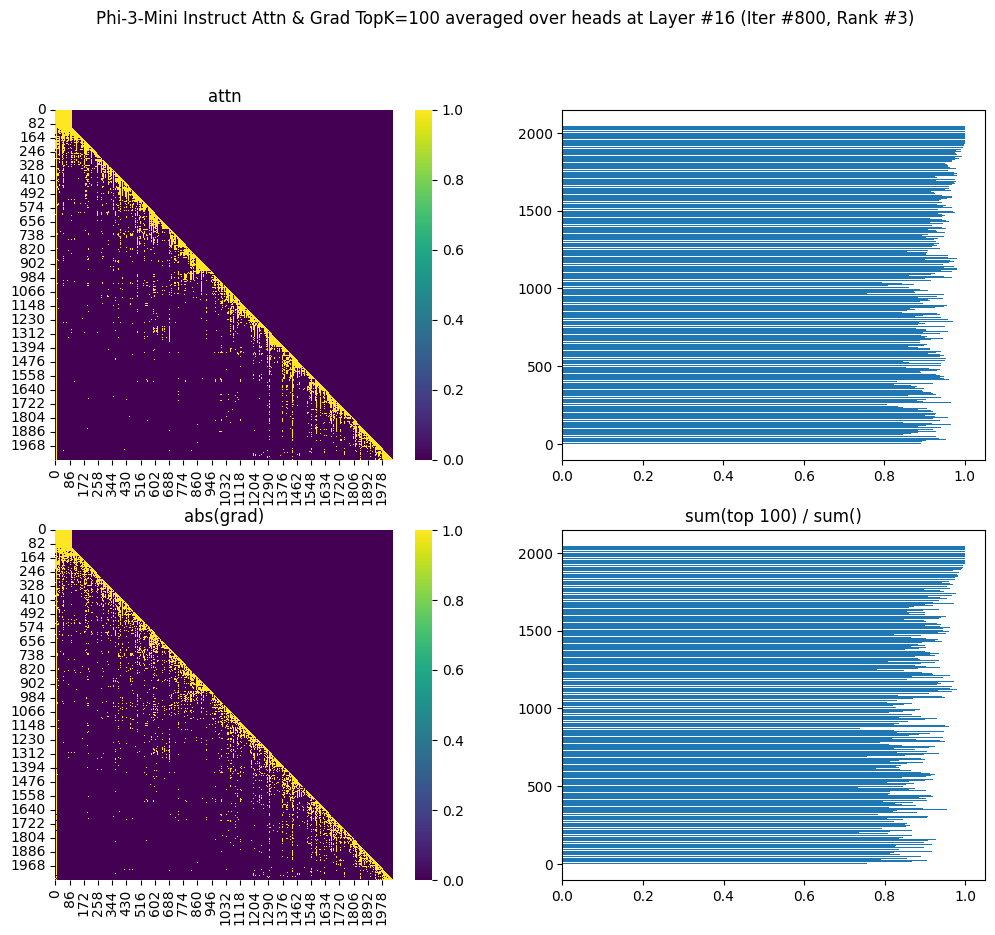

In [47]:
K = 100
iter_idx = 800
layer_idx = 16
head_idx = None
rank = 3


num_rows, num_cols = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    iter_idx=iter_idx, 
    layer_idx=layer_idx, 
    rank=rank, 
    head_idx=head_idx, 
    topk=K,
    causal=False,
    
)

if head_idx:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} (Iter #{iter_idx}, Layer #{layer_idx}, Head #{head_idx}, Rank #{rank})')
else:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} averaged over heads at Layer #{layer_idx} (Iter #{iter_idx}, Rank #{rank})')

--------------------------------------------------------------------------------
Loading data for iteration 800


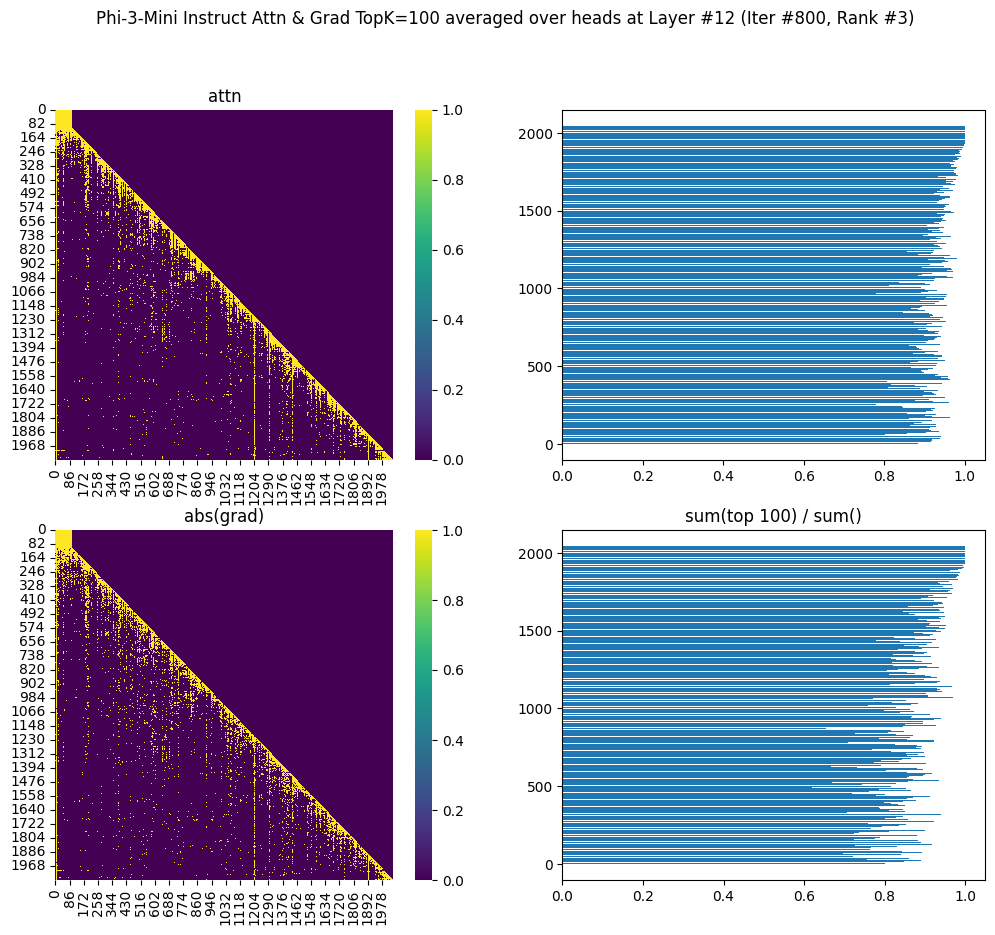

In [48]:
K = 100
iter_idx = 800
layer_idx = 12
head_idx = None
rank = 3


num_rows, num_cols = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    iter_idx=iter_idx, 
    layer_idx=layer_idx, 
    rank=rank, 
    head_idx=head_idx, 
    topk=K,
    causal=False,
    
)

if head_idx:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} (Iter #{iter_idx}, Layer #{layer_idx}, Head #{head_idx}, Rank #{rank})')
else:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} averaged over heads at Layer #{layer_idx} (Iter #{iter_idx}, Rank #{rank})')

--------------------------------------------------------------------------------
Loading data for iteration 800


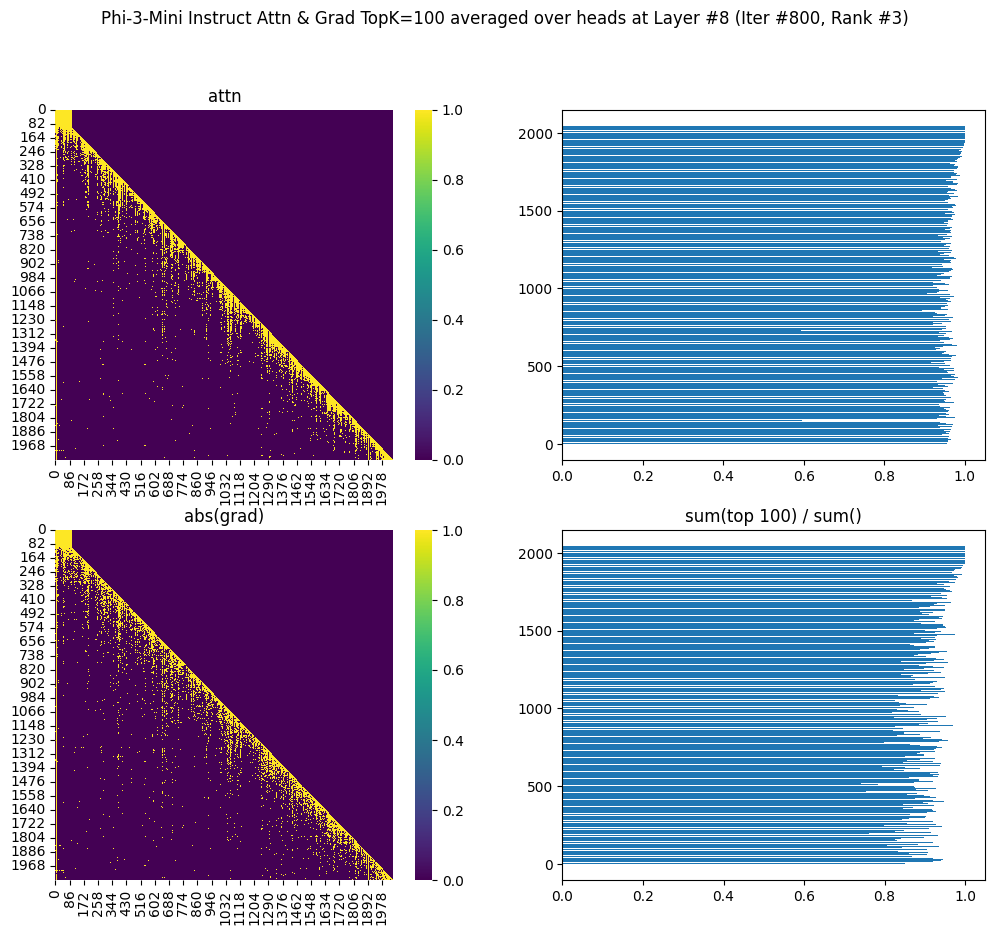

In [49]:
K = 100
iter_idx = 800
layer_idx = 8
head_idx = None
rank = 3


num_rows, num_cols = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    iter_idx=iter_idx, 
    layer_idx=layer_idx, 
    rank=rank, 
    head_idx=head_idx, 
    topk=K,
    causal=False,
    
)

if head_idx:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} (Iter #{iter_idx}, Layer #{layer_idx}, Head #{head_idx}, Rank #{rank})')
else:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} averaged over heads at Layer #{layer_idx} (Iter #{iter_idx}, Rank #{rank})')

--------------------------------------------------------------------------------
Loading data for iteration 800


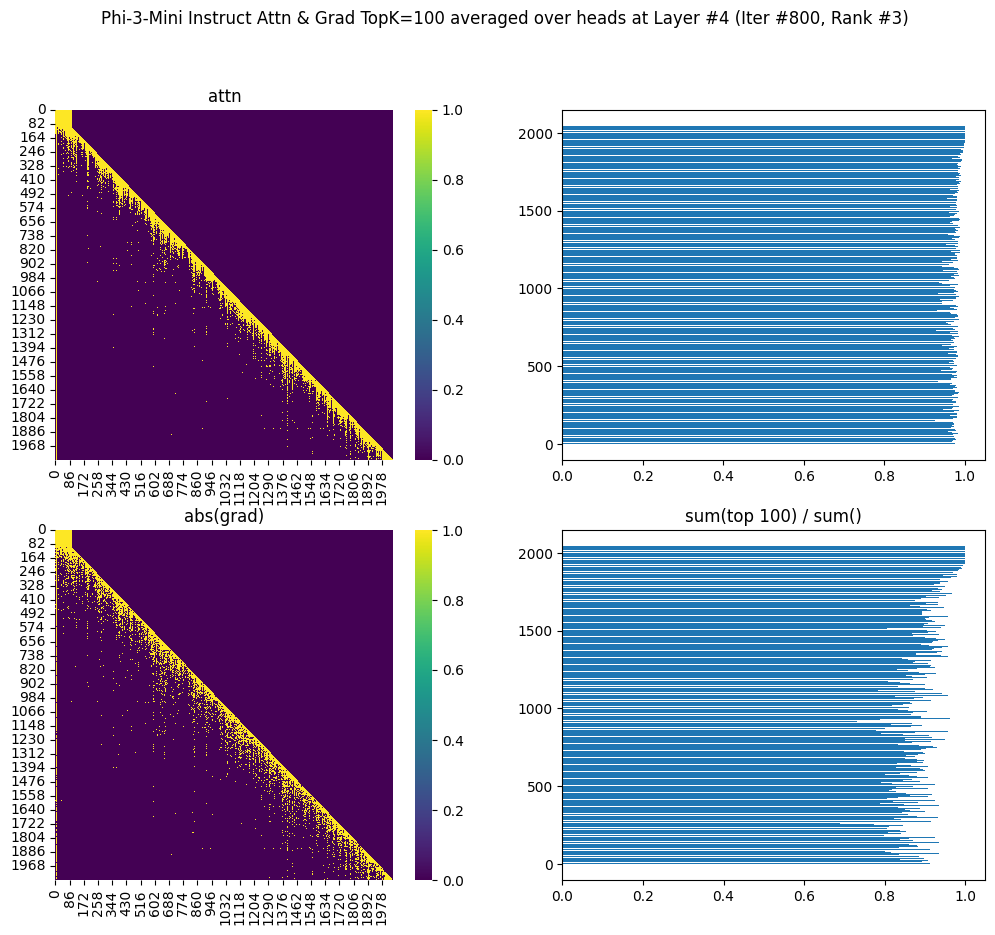

In [50]:
K = 100
iter_idx = 800
layer_idx = 4
head_idx = None
rank = 3


num_rows, num_cols = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    iter_idx=iter_idx, 
    layer_idx=layer_idx, 
    rank=rank, 
    head_idx=head_idx, 
    topk=K,
    causal=False,
    
)

if head_idx:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} (Iter #{iter_idx}, Layer #{layer_idx}, Head #{head_idx}, Rank #{rank})')
else:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} averaged over heads at Layer #{layer_idx} (Iter #{iter_idx}, Rank #{rank})')


--------------------------------------------------------------------------------
Loading data for iteration 800


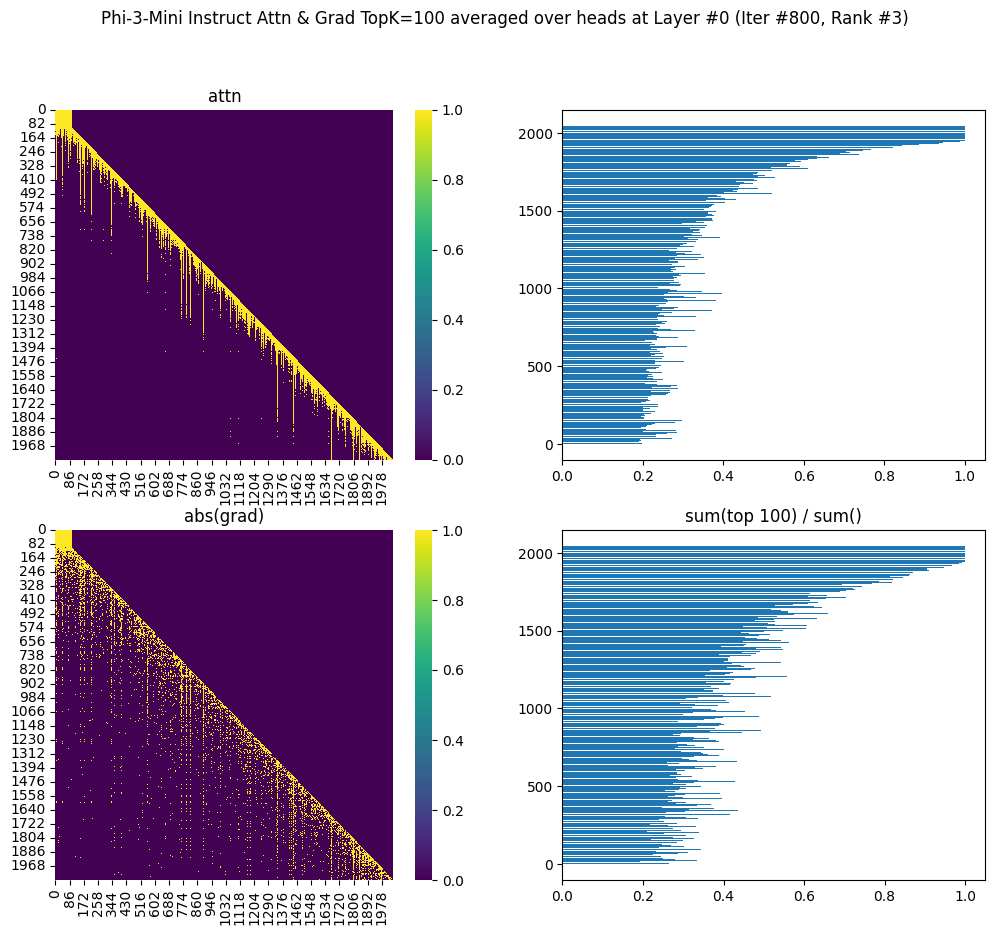

In [51]:
K = 100
iter_idx = 800
layer_idx = 0
head_idx = None
rank = 3


num_rows, num_cols = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))

plot_attn_topk(
    axes, 
    iter_idx=iter_idx, 
    layer_idx=layer_idx, 
    rank=rank, 
    head_idx=head_idx, 
    topk=K,
    causal=False,
    
)

if head_idx:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} (Iter #{iter_idx}, Layer #{layer_idx}, Head #{head_idx}, Rank #{rank})')
else:
    plt.suptitle(f'Phi-3-Mini Instruct Attn & Grad TopK={K} averaged over heads at Layer #{layer_idx} (Iter #{iter_idx}, Rank #{rank})')